### 히스토그램 역투영
#### 히스토그램 역투영은 물체의 모양은 무시하고 단순히 컬러 분포만으로 검출하는 방법이다.
#### 이를 이용해 사람의 얼굴을 검출할 수 있다.
#### 이때 히스토그램은 명안 채널만 이용하는 1차원이 아니라, 최소 2차원 이상을 사용해야 한다. 명안은 조명에 따라 쉽게 변할 뿐만 아니라 얼굴과 비슷한 명암을 갖는 다른 영역이 여러 군데 존재할 가능성이 높아, 명안만 사용하면 피부에 해당하는 영역을 구별하기 어렵다. 따라서 RGB 색상 공간을 HSI 공간으로 변환한 다음, H(색상, Hue)와 S(채도, Saturation) 채널을 사용한다.
#### histogram의 역투영은 다음과 같이 계산된다.
$$
h_{r}(i,j)=min(\frac{\hat{h}_{m}(i,j)}{\hat{h}_{i}(i,j)},0,1) \ , 0 \le j \ , \ i \le q-1
$$
#### 여기서 hm은 얼굴 색상을 추출한 정규화된 히스토그램이고 hi은 타겟의 정규화된 히스토그램이다. L의 크기가 클수록 (픽셀의 최대 값) 매우 희소한 공간에 존재하기 때문에 q단계로 줄여서 한다. 식을 이해해 보자면 hm이 hi이상인 영역을 나타내는 것이다.



#### 이번 예제는 다음 두 사진을 이용해서 한다. 왼쪽 그림에서 얼굴에 해당하는 히스토그램을 추출하고 오른쪽그림에 역투영을 적용한다.

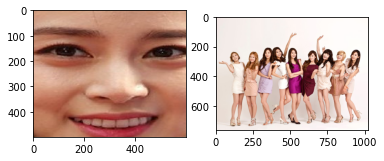

In [1]:
import numpy as np
import cv2
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

img = cv2.imread('./data/kim.jpg')
img2 = cv2.imread('./data/girlsgeneration.JPG')

plt.subplot(121)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
plt.show()

#### 다음으로 rgb에서 hsi로 변환하는 함수를 작성한다.

In [2]:
def rgb_to_hsi(img):
    heigh,width,channel = img.shape
    img_flat = np.reshape(img.copy(),[-1,channel])/255
    i = np.mean(img_flat, -1, keepdims=True)
    if channel==1:
        h = np.zeros_like(img_flat[...,2])
        s = np.zeros_like(img_flat[...,2])
    else:
        r = img_flat[...,2]
        g = img_flat[...,1]
        b = img_flat[...,0]
        mins = np.min(img_flat,axis=1,keepdims=True)
        s = 1-mins/i
        theta = np.arccos(((r-g)+(r-b))/(np.sqrt((r-g)**2+(r-b)*(g-b))*2))* 180 / np.pi
        h = np.expand_dims(np.where(b>g,360-theta,theta),-1)
        h/=360
    hsi = np.concatenate([h,s,i],-1)
    return np.uint8(np.clip(np.reshape(hsi,[heigh,width,channel])*255,0,255))

hsi = rgb_to_hsi(img)

#### 0~255의 값을 가지므로 L은 현재 256, 이 공간을 줄이기 위해 q는 64로 설정했다.
#### 우선 히스토그램을 구하고 3차원 공간에서 확인을 해보자

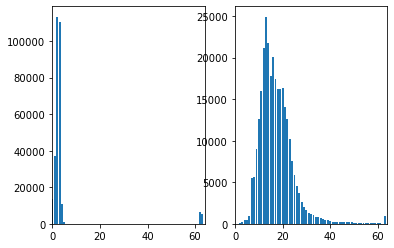

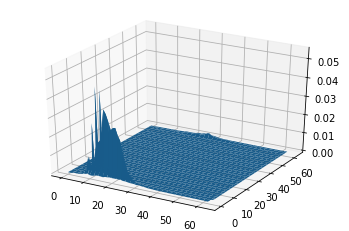

In [3]:
L=256
q=64

hs_hist = np.zeros((q,q),np.float)
h_hist = np.zeros((q,1),np.int)
s_hist = np.zeros((q,1),np.int)

src_height, src_width ,_ = img.shape

hsi_flat = np.reshape(hsi.copy(),[-1,3])
for i in range(len(hsi_flat)):
    hs_hist[int(hsi_flat[i,0]*q/L)][int(hsi_flat[i,1]*q/L)]+=1
    h_hist[int(hsi_flat[i,0]*q/L)]+=1
    s_hist[int(hsi_flat[i,1]*q/L)]+=1

hs_hist=hs_hist/(src_width*src_height)

x = np.arange(q)
y = np.arange(q)
xx,yy = np.meshgrid(x,y)

plt.subplot(121)
plt.bar(x,h_hist.squeeze())
plt.xlim([0,q])
plt.subplot(122)
plt.bar(x,s_hist.squeeze())
plt.xlim([0,q])

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx,yy,hs_hist.squeeze())

plt.show()

#### 타겟 이미지에서도 마찬가지로 히스토그램을 구한다.

In [4]:
dst_height,dst_width,_ = img2.shape
dst_hs_hist = np.zeros((q,q),np.float)
dst_hsi = rgb_to_hsi(img2)
hsi_flat = np.reshape(dst_hsi.copy(),[-1,3])

for i in range(len(hsi_flat)):
    dst_hs_hist[int(hsi_flat[i,0]*q/L)][int(hsi_flat[i,1]*q/L)]+=1
dst_hs_hist=dst_hs_hist/(dst_width*dst_height)

C:\ProgramData\Anaconda3\envs\test_code\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


#### 이제 타겟의 hsi영역에서 히스토그램을 역투영하면 얼굴 영역에서 검출이 완료된다.

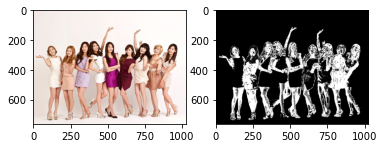

In [5]:
dst = np.zeros([dst_height,dst_width])
for y in range(dst_height):
    for x in range(dst_width):
        h=int(dst_hsi[y, x,0] * q / L)
        s=int(dst_hsi[y,x,1]*q/L)
        dst[y][x]=np.clip(hs_hist[h,s]/dst_hs_hist[h,s],0,1)*255
        
plt.subplot(121)
plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(dst, cmap='gray')
plt.show()

#### Opencv에서는 q를 사용하지는 않지만 좀더 간단하게 구현할 수 있다.
#### Opencv에서는 RGB2HSI가 지원되지 않는다. 따라서 HSV를 이용해서 구현을 한다. (HSI와 HSV의 수식이 조금 달라서 약간의 차이가 난다.)

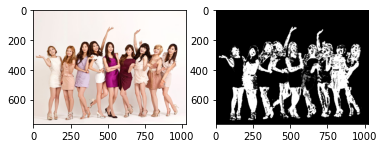

In [6]:
cv_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
cv_hsv2 = cv2.cvtColor(img2,cv2.COLOR_BGR2HSV)


cv_hs_hist = cv2.calcHist([cv_hsv], [0,1], None, [180,256], [0,180,0, 256])
cv2.normalize(cv_hs_hist,cv_hs_hist,0,255,cv2.NORM_MINMAX)
cv_dst=cv2.calcBackProject([cv_hsv2],[0,1], cv_hs_hist,[0,180,0,256],1) # 역투영함수
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)) # smooding mask
cv2.filter2D(cv_dst,-1,disc,cv_dst) # smoothing

plt.subplot(121)
plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv_dst, cmap='gray')
plt.show()

#### 다음과 같이 하면 검출된 영역에서 색상영상을 띄울수도 있다.

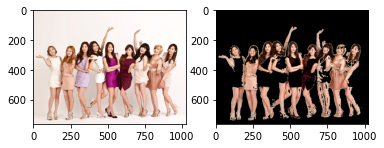

In [7]:
_,thr = cv2.threshold(cv_dst,5,255,0)
thr = cv2.merge((thr,thr,thr))
cv_dst = cv2.bitwise_and(img2,thr)

plt.subplot(121)
plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(cv_dst,cv2.COLOR_BGR2RGB))
plt.show()